# Accident Hotspot Prediction

Road safety is of paramount importance for the Government and the entire mobility ecosystem. While the number of road accidents has reduced over the last couple of years, still the overall number of accidents that occurred in 2017 is alarming. It has been assessed that 90% of the accident fatalities occur due to human error. “Brasilia Declaration on Road Safety” envisages to halve road traffic deaths by the end of this decade. There are number of interventions being adopted to reduce the occurrence of the road accidents. A technological solution/platform which can rate driver behavior and predict accident hot spot is the need of the hour. This will enable enforcement agencies and the commuters to take preemptive actions to avoid accidents.

The prediction is carried out by taking the example of Bengaluru. We first take the JSON data of Bengaluru and convert it to XLSX using an online tool for better readability. 

In [2]:
import pandas as pd
import numpy as np

In [3]:
bdf = pd.read_excel('bangalore-cas-alerts.xlsx')

In [4]:
bdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207617 entries, 0 to 207616
Data columns (total 7 columns):
deviceCode_deviceCode                 207617 non-null int64
deviceCode_location_latitude          207617 non-null float64
deviceCode_location_longitude         207617 non-null float64
deviceCode_location_wardName          207617 non-null object
deviceCode_pyld_alarmType             207617 non-null object
deviceCode_pyld_speed                 207617 non-null int64
deviceCode_time_recordedTime_$date    207617 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 11.1+ MB


In [5]:
bdf.head(10)

,deviceCode_deviceCode,deviceCode_location_latitude,deviceCode_location_longitude,deviceCode_location_wardName,deviceCode_pyld_alarmType,deviceCode_pyld_speed,deviceCode_time_recordedTime_$date
0,864504031502210,12.984595,77.744087,Kadugodi,PCW,32,2018-02-01T01:48:59.000Z
1,864504031502210,12.984595,77.744087,Kadugodi,PCW,32,2018-02-01T01:48:59.000Z
2,864504031502210,12.987233,77.741119,Garudachar Playa,FCW,41,2018-02-01T01:50:00.000Z
3,864504031502210,12.987233,77.741119,Garudachar Playa,FCW,41,2018-02-01T01:50:00.000Z
4,864504031502210,12.987503,77.740051,Hudi,Overspeed,37,2018-02-01T01:50:11.000Z
5,864504031502210,12.987503,77.740051,Hudi,Overspeed,37,2018-02-01T01:50:11.000Z
6,864504031502210,12.987523,77.736702,Kadugodi,HMW,32,2018-02-01T01:50:50.000Z
7,864504031502210,12.987523,77.736702,Kadugodi,HMW,32,2018-02-01T01:50:50.000Z
8,864504031502210,12.988210,77.731369,Hudi,Overspeed,27,2018-02-01T01:52:26.000Z
9,864504031502210,12.988210,77.731369,Hudi,Overspeed,27,2018-02-01T01:52:26.000Z


We rename the timestamp column for better readability.

In [6]:
bdf = bdf.rename(columns = {'deviceCode_time_recordedTime_$date':'timestamp'})

We extract the date from the timestamp using the inbuilt functions of pandas and datetime libraries.

In [7]:
bdf['timestamp'] = pd.to_datetime(bdf['timestamp'])
bdf['eventDate'] = pd.to_datetime(bdf['timestamp'])
bdf['eventDate'] = bdf['eventDate'].dt.strftime('%Y%m%d')

We take the hour during which the event occured and map them to different categories to later study if the vehicle was observed during peak hours, early hours, regular hours and so on.

In [8]:
bdf['e_hour'] = pd.to_datetime(bdf['timestamp'], format = '%H:%M:%S').dt.hour
bdf['ehourCat'] = 0
bdf['ehourCat'] = np.where((bdf['e_hour'] >= 0) & (bdf['e_hour'] < 6), 1, bdf['ehourCat'])
bdf['ehourCat'] = np.where((bdf['e_hour'] >= 6) & (bdf['e_hour'] < 10), 2, bdf['ehourCat'])
bdf['ehourCat'] = np.where((bdf['e_hour'] >= 10) & (bdf['e_hour'] < 16), 3, bdf['ehourCat'])
bdf['ehourCat'] = np.where((bdf['e_hour'] >= 16) & (bdf['e_hour'] < 21), 4, bdf['ehourCat'])
bdf['ehourCat'] = np.where((bdf['e_hour'] >= 21) & (bdf['e_hour'] < 24), 5, bdf['ehourCat'])

Currently, we have features such as speed, area, latitude, longitude, the time when the observation was made. In addition to these feature, we believe it would be beneficial to have the weather conditions when these events were observed. In order to do so, we scrape the weather data of Bangalore for the period of February until July 2018 from: https://www.timeanddate.com/weather/india/bangalore

The follow block of code below scrapes the weather data and saves it to another XLSX file.

In [9]:
from time import time
from datetime import timedelta
import datetime
from urllib.request import urlopen
import re
from pandas import ExcelWriter

def date_splitter(dateToSplit):
    dateToSplit = dateToSplit.split('-', 1)
    year = dateToSplit[0]
    dateToSplit = dateToSplit[1].split('-', 1)
    month = dateToSplit[0]
    day = dateToSplit[1]
    return year, month, day

def extractTime(s):
    time = re.findall('\d+:\d+', s)
    return time

def extractConditions(s):
    x = re.findall('"small",h:"', s)
    condList = []
    for i in range(len(x)):
        s = s.split('"small",h:"', 1)
        s = s[1].split('."},{s', 1)
        condList.append(s[0])
        s = s[1]
    return condList

def extractVisibility(s):
    s = s.replace('&nbsp;', '')
    re1 = '(\\d+)'
    re2 = ''
    re3 = 'km'
    visibilities = re.findall(re1 + re2 + re3, s)
    return visibilities

def extractTemperature(s):
    s = s.replace('°', '')
    s = s.replace('&nbsp;', '')
    re1='\d+'
    re2='[A-Z]'
    temperatures = re.findall(re1 + re2, s)
    tempList = list()
    for i in range(len(temperatures)):
        x = re.findall(re1, temperatures[i])[0]
        tempList.append(x)
    return tempList

finalRawDf = pd.DataFrame()

# datetime.date.today equals 26th August, 2018. Change accordingly to make the script work for the duration of scraping

for i in range(26, 193):
    startDate = str(datetime.date(2018, 8, 26) + timedelta(days = -i))
    d_year, d_month, d_day = date_splitter(startDate)
    finalDate = d_year + d_month + d_day
    if d_month == '02':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=2&year=2018&json=1'
    elif d_month == '03':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=3&year=2018&json=1'
    elif d_month == '04':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=4&year=2018&json=1'
    elif d_month == '05':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=5&year=2018&json=1'
    elif d_month == '06':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=6&year=2018&json=1'
    elif d_month == '07':
        link = 'https://www.timeanddate.com/scripts/cityajax.php?n=india/bangalore&mode=historic&hd=' + finalDate + '&month=7&year=2018&json=1'

    #print('Scraping:', link)
    html = urlopen(link)
    s = html.read().decode('utf-8')

    times = extractTime(s)
    visibility = extractVisibility(s)
    temperature = extractTemperature(s)
    condition = extractConditions(s)

    if(len(visibility) < len(condition)):
        remLength = len(condition) - len(visibility)
        for i in range(remLength):
            visibility.append(visibility[0])

    tempDf = pd.DataFrame({
            'weatherDate': finalDate,
            'time': times,
            'temperature': temperature,
            'visibility': visibility,
            'condition': condition
            })

    finalRawDf = finalRawDf.append(tempDf)

print('Finished scraping weather data!')
writer = ExcelWriter('bangalore-weather.xlsx')
finalRawDf.to_excel(writer, index = False, sheet_name = 'Sheet1')
writer.save()

Finished scraping weather data!


We read the scraped data file now to get a glimpse of the contents.

In [10]:
bwdf = pd.read_excel('bangalore-weather.xlsx')

In [11]:
bwdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4636 entries, 0 to 4635
Data columns (total 5 columns):
condition      4636 non-null object
temperature    4636 non-null int64
time           4636 non-null object
visibility     4636 non-null int64
weatherDate    4636 non-null int64
dtypes: int64(3), object(2)
memory usage: 181.2+ KB


In [12]:
bwdf.head(10)

,condition,temperature,time,visibility,weatherDate
0,Partly cloudy,20,05:30,8,20180731
1,Partly cloudy,20,06:00,6,20180731
2,Broken clouds,21,07:00,6,20180731
3,Broken clouds,22,07:30,6,20180731
4,Broken clouds,22,08:00,6,20180731
5,Broken clouds,22,08:30,6,20180731
6,Broken clouds,23,09:00,6,20180731
7,Broken clouds,24,09:30,6,20180731
8,Scattered clouds,24,10:00,8,20180731
9,Scattered clouds,24,10:30,8,20180731


We follow similar strategy here to get the hour to equate it to the hour from the previous dataframe of events recorded by the Collision Avoidance System.

In [13]:
bwdf['w_hour'] = pd.to_datetime(bwdf['time'], format= '%H:%M').dt.hour
bwdf['hourCat'] = 0
bwdf['hourCat'] = np.where((bwdf['w_hour'] >= 0) & (bwdf['w_hour'] < 6), 1, bwdf['hourCat'])
bwdf['hourCat'] = np.where((bwdf['w_hour'] >= 6) & (bwdf['w_hour'] < 10), 2, bwdf['hourCat'])
bwdf['hourCat'] = np.where((bwdf['w_hour'] >= 10) & (bwdf['w_hour'] < 16), 3, bwdf['hourCat'])
bwdf['hourCat'] = np.where((bwdf['w_hour'] >= 16) & (bwdf['w_hour'] < 21), 4, bwdf['hourCat'])
bwdf['hourCat'] = np.where((bwdf['w_hour'] >= 21) & (bwdf['w_hour'] < 24), 5, bwdf['hourCat'])
bwdf = bwdf.drop_duplicates(subset = ['weatherDate', 'hourCat'], keep = 'first')
bwdf['ehourCat'] = bwdf['hourCat']
bwdf['weatherDate'] = bwdf['weatherDate'].astype(str)

To merge the two dataframes on a mutual column, we create an extra column with the same name weatherDate in our previous dataframe bdf.

In [14]:
bdf['weatherDate'] = bdf['eventDate']
bdf['weatherDate'] = bdf['weatherDate'].astype(str)

In [15]:
b1 = pd.merge(bdf, bwdf, on = ['weatherDate', 'ehourCat'], how = 'left')

Our merged dataset now looks like shown below.

In [16]:
b1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207617 entries, 0 to 207616
Data columns (total 17 columns):
deviceCode_deviceCode            207617 non-null int64
deviceCode_location_latitude     207617 non-null float64
deviceCode_location_longitude    207617 non-null float64
deviceCode_location_wardName     207617 non-null object
deviceCode_pyld_alarmType        207617 non-null object
deviceCode_pyld_speed            207617 non-null int64
timestamp                        207617 non-null datetime64[ns]
eventDate                        207617 non-null object
e_hour                           207617 non-null int64
ehourCat                         207617 non-null int64
weatherDate                      207617 non-null object
condition                        190275 non-null object
temperature                      190275 non-null float64
time                             190275 non-null object
visibility                       190275 non-null float64
w_hour                           190275 n

In [17]:
b1.head(10)

,deviceCode_deviceCode,deviceCode_location_latitude,deviceCode_location_longitude,deviceCode_location_wardName,deviceCode_pyld_alarmType,deviceCode_pyld_speed,timestamp,eventDate,e_hour,ehourCat,weatherDate,condition,temperature,time,visibility,w_hour,hourCat
0,864504031502210,12.984595,77.744087,Kadugodi,PCW,32,2018-02-01 01:48:59,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
1,864504031502210,12.984595,77.744087,Kadugodi,PCW,32,2018-02-01 01:48:59,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
2,864504031502210,12.987233,77.741119,Garudachar Playa,FCW,41,2018-02-01 01:50:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
3,864504031502210,12.987233,77.741119,Garudachar Playa,FCW,41,2018-02-01 01:50:00,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
4,864504031502210,12.987503,77.740051,Hudi,Overspeed,37,2018-02-01 01:50:11,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
5,864504031502210,12.987503,77.740051,Hudi,Overspeed,37,2018-02-01 01:50:11,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
6,864504031502210,12.987523,77.736702,Kadugodi,HMW,32,2018-02-01 01:50:50,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
7,864504031502210,12.987523,77.736702,Kadugodi,HMW,32,2018-02-01 01:50:50,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
8,864504031502210,12.988210,77.731369,Hudi,Overspeed,27,2018-02-01 01:52:26,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN
9,864504031502210,12.988210,77.731369,Hudi,Overspeed,27,2018-02-01 01:52:26,20180201,1,1,20180201,NaN,NaN,NaN,NaN,NaN,NaN


We rename the warname column to Area.

In [18]:
b1 = b1.rename(columns = {'deviceCode_location_wardName':'Area'})

The dataset we have currently does not mention about the accident prone zones of Bengaluru. This information was obtained from: http://bengaluru.citizenmatters.in/top-10-places-where-most-accidents-in-bengaluru-take-place-7260

We mapped the areas which we have in our dataset to the nearest accident prone zone marked in the link based on the number of fatalities reported by the traffic police. We performed this task manually. 

Similary, we also obtained the pothole data of Bengaluru from this link and repeated the task of mapping the pothole centric areas to the areas in our initial dataset. The pothole data was obtained manually from: https://www.potholeraja.com/live-potholeview

In [19]:
badf = pd.read_excel('bangalore-accident-zones.xlsx')

We have a look at the data of accident prone zones and pothole centric zones of Bengaluru. 

In [20]:
badf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
Area                 50 non-null object
Mapped_Location      50 non-null object
Accident_Severity    50 non-null object
Pothole_Severity     50 non-null object
dtypes: object(4)
memory usage: 1.6+ KB


In [21]:
badf.head(10)

,Area,Mapped_Location,Accident_Severity,Pothole_Severity
0,A Narayanapura,Electronic City,High,High
1,Agaram,Electronic City,High,High
2,Banasavadi,Banasavadi,Low,Low
3,Basavanapura,K R Puram,Medium,High
4,Bellanduru,Electronic City,High,High
5,Benniganahalli,Banasavadi,Low,Low
6,Bharathi Nagar,K R Puram,Medium,High
7,BTM Layout,Madivala,High,Medium
8,C V Raman Nagar,Banasavadi,Low,Low
9,Chickpete,Madivala,High,Low


We merge this data to our initial dataset.

In [22]:
b = pd.merge(b1, badf, on = ['Area'], how = 'left')

We rename the Alarm type and Plying speed columns for better readability.

In [23]:
b = b.rename(columns = {'deviceCode_pyld_alarmType':'Alarm_Type'})
b = b.rename(columns = {'deviceCode_pyld_speed':'Plying_Speed'})

The city speed limit of Bengaluru is 50kmph but given that some of the roads may connect to highways, we have given extra buffer of 10kmph to mark it as an event of Overpseeding. The source of this information can be found here: http://www.bangaloretrafficpolice.gov.in/faqs.html

In [24]:
b['hasOversped'] = np.where(b.Plying_Speed > 60, 1, 0)
b['hasOversped'] = np.where(b.Alarm_Type == 'Overspeed', 1, b['hasOversped'])

We inspect the current dataset we have to see how it looks so far. 

In [25]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207617 entries, 0 to 207616
Data columns (total 21 columns):
deviceCode_deviceCode            207617 non-null int64
deviceCode_location_latitude     207617 non-null float64
deviceCode_location_longitude    207617 non-null float64
Area                             207617 non-null object
Alarm_Type                       207617 non-null object
Plying_Speed                     207617 non-null int64
timestamp                        207617 non-null datetime64[ns]
eventDate                        207617 non-null object
e_hour                           207617 non-null int64
ehourCat                         207617 non-null int64
weatherDate                      207617 non-null object
condition                        190275 non-null object
temperature                      190275 non-null float64
time                             190275 non-null object
visibility                       190275 non-null float64
w_hour                           190275 n

Some of the columns do not have enough entries compared to our initial entries. This is due to the fact that the weather scraper could not find information for all the hours when the events were recorded by the Collision Avoidance System. Hence, we replace the NaN data for which we could not find information with the Mode values, that is the most frequently occuring values of certain columns which we will use for our final prediction.

In [26]:
for column in ['temperature', 'visibility', 'condition']:
    b[column].fillna(b[column].mode()[0], inplace=True)

In [27]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207617 entries, 0 to 207616
Data columns (total 21 columns):
deviceCode_deviceCode            207617 non-null int64
deviceCode_location_latitude     207617 non-null float64
deviceCode_location_longitude    207617 non-null float64
Area                             207617 non-null object
Alarm_Type                       207617 non-null object
Plying_Speed                     207617 non-null int64
timestamp                        207617 non-null datetime64[ns]
eventDate                        207617 non-null object
e_hour                           207617 non-null int64
ehourCat                         207617 non-null int64
weatherDate                      207617 non-null object
condition                        207617 non-null object
temperature                      207617 non-null float64
time                             190275 non-null object
visibility                       207617 non-null float64
w_hour                           190275 n

The temperature, condition and visibility columns have the same number of records since we replaced them with the Mode values of each of those columns.

We create a flag for low and high visibility. Anything great than 10 would be equated to high visibility whereas the other case would be low visibility. 

In [28]:
b['visibility'] = np.where(b['visibility'] < 10, 0, 1)

We now map all the columns we need to its numerical equivalent in the form of flags. 

In [29]:
df = b.copy()
df['hasOversped'] = np.where(b.hasOversped == 1, 'Yes', 'No')
df['visibility'] = np.where(b.visibility == 0, 'Low', 'High')
df['ehourCat'] = b['ehourCat'].map({1: 'Early', 2: 'PeakM', 3: 'RegularM'})
b['Accident_Severity'] = b['Accident_Severity'].map({'High': 3, 'Medium': 2, 'Low': 1})
b['Pothole_Severity'] = b['Pothole_Severity'].map({'High': 3, 'Medium': 2, 'Low': 1})
b['Alarm_Type'] = b['Alarm_Type'].map({'PCW': 1, 'FCW': 2, 'Overspeed': 3, 'HMW': 4, 'UFCW': 5, 'LDWL': 6, 'LDWR': 7})
b['condition'] = b['condition'].map({'Clear': 1, 'Sunny': 2, 'Passing clouds': 3,
       'Broken clouds': 4, 'Scattered clouds': 5, 'Fog': 6, 'Haze': 7, 'Partly cloudy': 8,
       'Mild': 9, 'Drizzle. Broken clouds': 10})
b['Area'] = b['Area'].map({'Kadugodi': 1, 'Garudachar Playa': 2, 'Hudi': 3, 'Other': 4, 'Devasandra': 5,
       'Hagadur': 6, 'Bellanduru': 7, 'Marathahalli': 8, 'Dodda Nekkundi': 9, 'Varthuru': 10,
       'HAL Airport': 11, 'Vijnana Nagar': 12, 'Konena Agrahara': 13, 'A Narayanapura': 14,
       'C V Raman Nagar': 15, 'Jeevanbhima Nagar': 16, 'HSR Layout': 17, 'Domlur': 18, 'Jogupalya': 19,
       'Hoysala Nagar': 20, 'New Tippasandara': 21, 'Benniganahalli': 22, 'Singasandra': 23,
       'Basavanapura': 24, 'Halsoor': 25, 'Agaram': 26, 'Shantala Nagar': 27, 'Sampangiram Nagar': 28,
       'Sudham Nagara': 29, 'Dharmaraya Swamy Temple': 30, 'Chickpete': 31, 'Banasavadi': 32,
       'Horamavu': 33, 'Kacharkanahalli': 34, 'Kammanahalli': 35, 'Vijnanapura': 36, 'Ramamurthy Nagar': 37,
       'K R Puram': 38, 'BTM Layout': 39, 'Madivala': 40, 'Gurappanapalya': 41, 'J P Nagar': 42, 'Sarakki': 43,
       'Jaraganahalli': 44, 'Vasanthpura': 45, 'Hemmigepura': 46, 'Yelchenahalli': 47,
       'Jayanagar East': 48, 'Bharathi Nagar': 49, 'other': 4})

writer = ExcelWriter('bangalore-consolidated-data.xlsx')
b.to_excel(writer, index = False, sheet_name = 'Sheet1')
df.to_excel(writer, index = False, sheet_name = 'Sheet2')
writer.save()

We get rid of the columns that we do not need and feel has no impact on the chance of accident likelihood. 

In [30]:
del b['deviceCode_deviceCode'], b['deviceCode_location_latitude'], b['deviceCode_location_longitude']
del b['w_hour'], b['Mapped_Location'], b['timestamp'], b['e_hour'], b['weatherDate']
del b['hourCat'], b['time'], b['temperature'], b['eventDate'], b['Plying_Speed']

del df['deviceCode_deviceCode'], df['deviceCode_location_latitude'], df['deviceCode_location_longitude']
del df['w_hour'], df['Mapped_Location'], df['timestamp'], df['e_hour'], df['weatherDate']
del df['hourCat'], df['time'], df['temperature'], df['eventDate'], df['Plying_Speed']

We now have two datasets: one that has all the data in words for understandability and the other in numerical format to fit to our prediction model.

In [31]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207617 entries, 0 to 207616
Data columns (total 8 columns):
Area                 207617 non-null int64
Alarm_Type           207617 non-null int64
ehourCat             207617 non-null int64
condition            207617 non-null int64
visibility           207617 non-null int64
Accident_Severity    207617 non-null int64
Pothole_Severity     207617 non-null int64
hasOversped          207617 non-null int64
dtypes: int64(8)
memory usage: 14.3 MB


In [32]:
b.head(10)

,Area,Alarm_Type,ehourCat,condition,visibility,Accident_Severity,Pothole_Severity,hasOversped
0,1,1,1,3,0,2,2,0
1,1,1,1,3,0,2,2,0
2,2,2,1,3,0,2,2,0
3,2,2,1,3,0,2,2,0
4,3,3,1,3,0,2,2,1
5,3,3,1,3,0,2,2,1
6,1,4,1,3,0,2,2,0
7,1,4,1,3,0,2,2,0
8,3,3,1,3,0,2,2,1
9,3,3,1,3,0,2,2,1


The equivalent dataset for this which can be in human understandable format is as below.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207617 entries, 0 to 207616
Data columns (total 8 columns):
Area                 207617 non-null object
Alarm_Type           207617 non-null object
ehourCat             207617 non-null object
condition            207617 non-null object
visibility           207617 non-null object
Accident_Severity    207617 non-null object
Pothole_Severity     207617 non-null object
hasOversped          207617 non-null object
dtypes: object(8)
memory usage: 14.3+ MB


In [34]:
df.head(10)

,Area,Alarm_Type,ehourCat,condition,visibility,Accident_Severity,Pothole_Severity,hasOversped
0,Kadugodi,PCW,Early,Passing clouds,Low,Medium,Medium,No
1,Kadugodi,PCW,Early,Passing clouds,Low,Medium,Medium,No
2,Garudachar Playa,FCW,Early,Passing clouds,Low,Medium,Medium,No
3,Garudachar Playa,FCW,Early,Passing clouds,Low,Medium,Medium,No
4,Hudi,Overspeed,Early,Passing clouds,Low,Medium,Medium,Yes
5,Hudi,Overspeed,Early,Passing clouds,Low,Medium,Medium,Yes
6,Kadugodi,HMW,Early,Passing clouds,Low,Medium,Medium,No
7,Kadugodi,HMW,Early,Passing clouds,Low,Medium,Medium,No
8,Hudi,Overspeed,Early,Passing clouds,Low,Medium,Medium,Yes
9,Hudi,Overspeed,Early,Passing clouds,Low,Medium,Medium,Yes


Since the data is unlabeled, we opt for unsupervised learning approach using clustering techniques. We have tried different clustering algorithms but we present the ones which gave us the most suitable labels as per our intuition.

In [35]:
from sklearn.cluster import KMeans
X = b.values.astype(np.float)
kmeans = KMeans(n_clusters = 2, max_iter = 2000, algorithm = 'full').fit(X)
kmf2labels = kmeans.labels_
kmf2labels = kmf2labels.tolist()
print('Finished clustering using K-Means')

Finished clustering using K-Means


While different variation of K-Means exists, we used the Expectation Maximization method. In order to get better convergence of our datapoints to centroid, we also increased the number of iterations from a default of 300 to 2000. The Expectation Maximization algorithm can be found here: https://en.wikipedia.org/wiki/Expectation–maximization_algorithm

We create two sets of clusters here: one for low likelihood accident zones whereas the other one for high likelihood accident zones. 

In [36]:
len(kmf2labels)

207617

So, we now have labels for all the data points from our dataset containing features: area, accident severity, pothole severity, speed, alarm type, overspeeding flag, hour category, visibility and sky conditions, which can be crucial towards understanding an accident would be taking place or not.

Let us join this list of labels to the dataframe to study them carefully.

In [37]:
b['labels'] = kmf2labels
df['labels'] = kmf2labels
df['labels'] = df['labels'].map({0: 'High', 1: 'Low'})

In [38]:
b.head(10)

,Area,Alarm_Type,ehourCat,condition,visibility,Accident_Severity,Pothole_Severity,hasOversped,labels
0,1,1,1,3,0,2,2,0,0
1,1,1,1,3,0,2,2,0,0
2,2,2,1,3,0,2,2,0,0
3,2,2,1,3,0,2,2,0,0
4,3,3,1,3,0,2,2,1,0
5,3,3,1,3,0,2,2,1,0
6,1,4,1,3,0,2,2,0,0
7,1,4,1,3,0,2,2,0,0
8,3,3,1,3,0,2,2,1,0
9,3,3,1,3,0,2,2,1,0


In [39]:
df.head(10)

,Area,Alarm_Type,ehourCat,condition,visibility,Accident_Severity,Pothole_Severity,hasOversped,labels
0,Kadugodi,PCW,Early,Passing clouds,Low,Medium,Medium,No,High
1,Kadugodi,PCW,Early,Passing clouds,Low,Medium,Medium,No,High
2,Garudachar Playa,FCW,Early,Passing clouds,Low,Medium,Medium,No,High
3,Garudachar Playa,FCW,Early,Passing clouds,Low,Medium,Medium,No,High
4,Hudi,Overspeed,Early,Passing clouds,Low,Medium,Medium,Yes,High
5,Hudi,Overspeed,Early,Passing clouds,Low,Medium,Medium,Yes,High
6,Kadugodi,HMW,Early,Passing clouds,Low,Medium,Medium,No,High
7,Kadugodi,HMW,Early,Passing clouds,Low,Medium,Medium,No,High
8,Hudi,Overspeed,Early,Passing clouds,Low,Medium,Medium,Yes,High
9,Hudi,Overspeed,Early,Passing clouds,Low,Medium,Medium,Yes,High


It can be seen that in cases of medium accident prone zones and pothole severities, overspeeding with low visibility during early hours of the data can have high chances of accident as per the given area and alarm type.

In [40]:
writer = ExcelWriter('bangalore-labeled-data.xlsx')
b.to_excel(writer, index = False, sheet_name = 'Sheet1')
df.to_excel(writer, index = False, sheet_name = 'Sheet2')
writer.save()

In [42]:
df[3251:3260]

,Area,Alarm_Type,ehourCat,condition,visibility,Accident_Severity,Pothole_Severity,hasOversped,labels
3251,Kadugodi,HMW,PeakM,Passing clouds,Low,Medium,Medium,No,High
3252,Kadugodi,HMW,PeakM,Passing clouds,Low,Medium,Medium,No,High
3253,Kadugodi,HMW,PeakM,Passing clouds,Low,Medium,Medium,No,High
3254,Bellanduru,Overspeed,PeakM,Passing clouds,Low,High,High,Yes,Low
3255,Bellanduru,Overspeed,PeakM,Passing clouds,Low,High,High,Yes,Low
3256,Bellanduru,HMW,PeakM,Passing clouds,Low,High,High,No,Low
3257,Bellanduru,HMW,PeakM,Passing clouds,Low,High,High,No,Low
3258,Bellanduru,HMW,PeakM,Passing clouds,Low,High,High,No,Low
3259,Bellanduru,HMW,PeakM,Passing clouds,Low,High,High,No,Low


From the above results, we can see areas with high accident prone zones and high potholes are more vulnerable to accidents no matter what the conditions are during the morning hours. 

In [43]:
import seaborn as sns

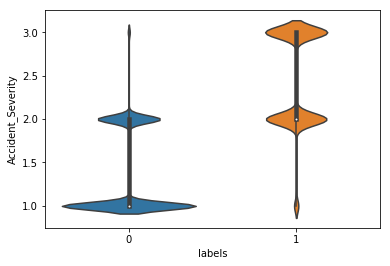

In [45]:
sns.violinplot(x = 'labels', y = 'Accident_Severity', data = b)

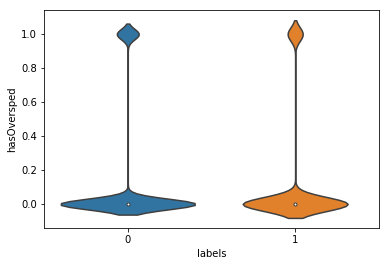

In [47]:
sns.violinplot(x = 'labels', y = 'hasOversped', data = b)

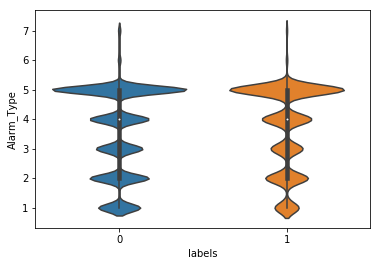

In [48]:
sns.violinplot(x = 'labels', y = 'Alarm_Type', data = b)

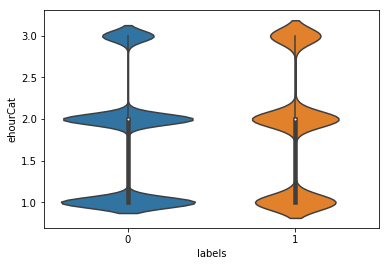

In [50]:
sns.violinplot(x = 'labels', y = 'ehourCat', data = b)

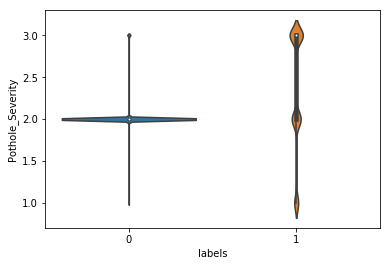

In [52]:
sns.violinplot(x = 'labels', y = 'Pothole_Severity', data = b)

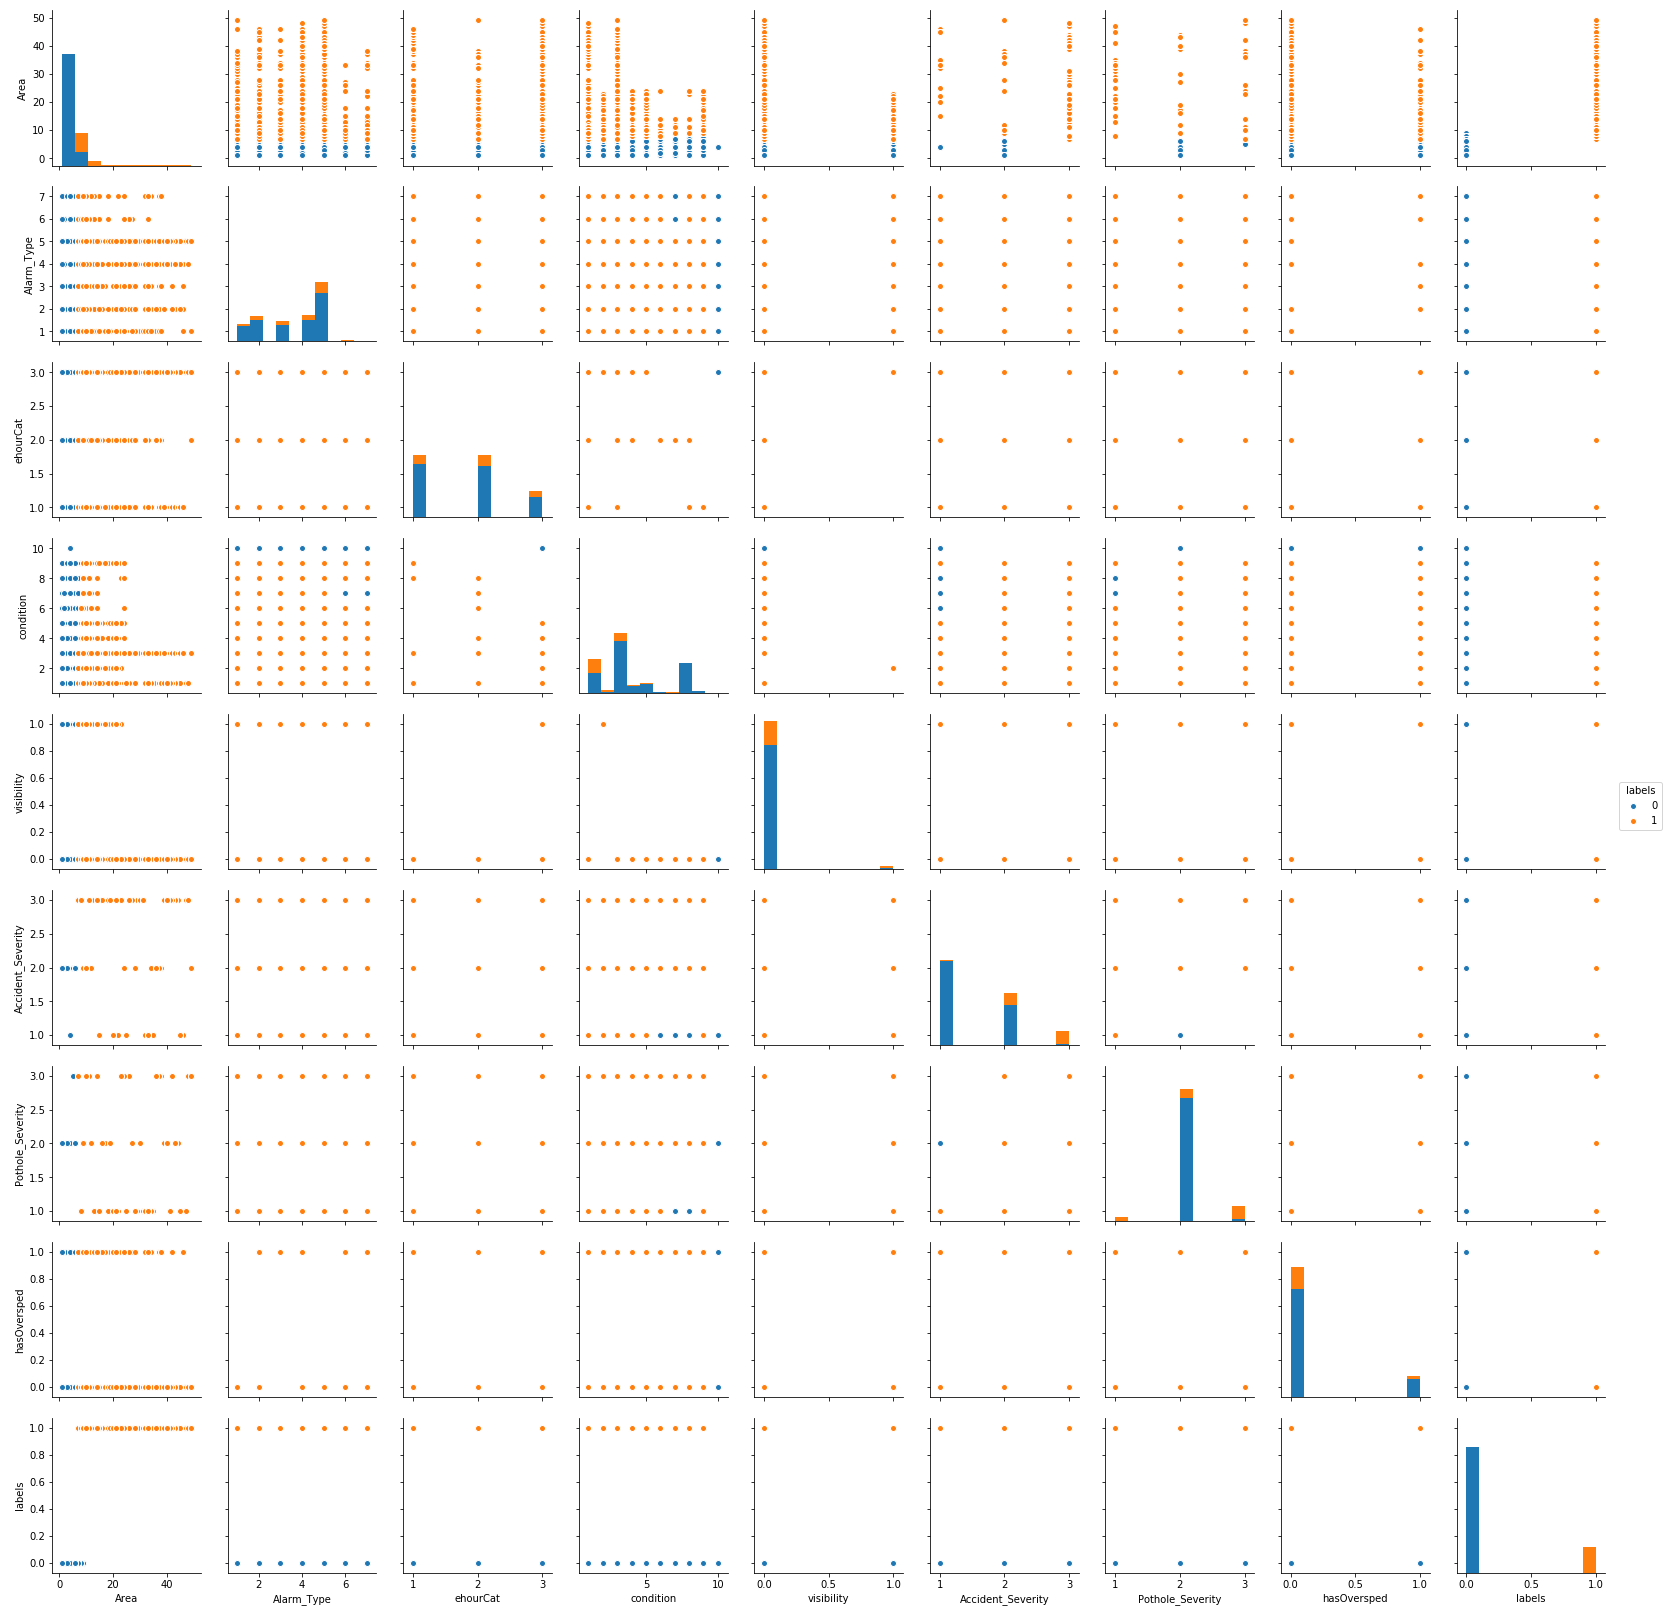

In [57]:
sns.pairplot(b, hue = 'labels')